In [1]:
%%bash
pip install sklearn

In [2]:
import os
import inspect
import sys
import pandas as pd
import charts
import numpy as np
import pylab as pl
from scipy import spatial
from scipy.spatial import distance
from scipy.signal import argrelextrema
from sklearn.cluster import MeanShift
import time
import math
from opengrid.library import houseprint

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean at 127.0.0.1:46489


In [3]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


<h1>Search a specific pattern in the sensordata</h1>

<h3>functions needed for the pattern recognition</h3>

In [4]:
def manhattanDistance(s1,s2):
    """
        Calculate the manhattan similarity between the original array (s1) and it's possible match (s2)
        
        PARAMETERS
        ----------
            s1: numpy array
            s2: numpy array
            
        RETURNS
        -------
            float
    """
    
    dist = distance.cityblock(s1,s2)
    
    return dist

In [51]:
def euclideanDistance(s1,s2):

    dist = np.linalg.norm(s1-s2)
    return dist

In [5]:
def loop_through_list(sensor_data, lookup_pattern):
    """
        This function slides the desired pattern over the total data stream and detects the pieces that have an
        acceptable similarity value (manhattanDistance)
        
        PARAMETERS
        ----------
            sensor_data: pandas dataframe
            lookup_pattern: pandas dataframe
            
        RETURNS
        -------
            numpy array
    """
    
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    compare_to_array=np.array(lookup_pattern)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    array_with_values=np.array(sensor_data)
    #start and stop timestamp
    starting_time_stamp=sensor_data.index[0]
    stop_time_stamp=sensor_data.index[lookup_pattern.size-1]
    
    #Threshold
    threshold_value=lookup_pattern.size/10
    
    #LOOPING THROUGH LIST
    while i < lookup_pattern.size+j: #i is dependent on j, i updates as j updates.
        #Save x amount of values where x is the size of the array to compare.
        values_list.append(([array_with_values[i][0]]))
        i=i+1
        
        if(i==(lookup_pattern.size+j)) and (i<(sensor_data.size)):
            
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            if(j==0) or (manhattanDistance(compare_to_array,values_list)!=result_list[len(result_list)-1][0]):
                #Create list with unique values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                result_list.append([manhattanDistance(compare_to_array,values_list), starting_time_stamp,stop_time_stamp]) 
            
            j=j+1
            starting_time_stamp=sensor_data.index[j] #startingTimeStamp: current minute considered
            stop_time_stamp=sensor_data.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            values_list=[]
    
    return result_list

In [6]:
def local_minima_ts_correction(result_list):
    """
        Checks if the selected 'best' matches overlap. In this case the match with the best similarity is kept
        
        PARAMETERS
        ----------
            result_list: numpy array
            
        RETURNS
        -------
            pandas dataframe
    """
    
    start=time.time()
    loop_index=0 #Loops through the resultslist, as long as its size
    current_saves=0 #Current amount of variables saved
    some_list=[]
    df_result=pd.DataFrame(some_list)
    ts=(result_list[0][2]-result_list[0][1])/10
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    
    #SAVING ONLY RELEVANT VALUES       
    while loop_index < len(result_list):
        
        if(loop_index==0):
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index][0], result_list[loop_index][1], result_list[loop_index][2]]
            df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            current_saves=current_saves+1
            
        if(result_list[loop_index-1][0] < result_list[loop_index-2][0]) and (result_list[loop_index-1][0] < result_list[loop_index][0]) and result_list[loop_index-1][0] < df_result.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index-1][0], result_list[loop_index-1][1], result_list[loop_index-1][2]]
            list_with_values=[]
            i=0
            max_value=0
            
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < df_result.index.size:
                if(start_time_stamp >= df_result['startTimeStamp'][i]) and (start_time_stamp <= df_result['stopTimeStamp'][i]-pd.Timedelta(minutes=threshold_value)):
                    
                    #INSIDE BOUNDARIES
                    if(df_result.loc[i][0] > max_value) and (df_result.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        max_value=df_result.loc[i][0]
                        ts=df_result.loc[i][1]
                    
                    elif(df_result.loc[i][0]==0): #PERFECT MATCH
                        max_value=1 #Not 0 because otherwise we assume it is outside of the boundaries
                i=i+1
                
            if(max_value==0): 
                #OUTSIDE BOUNDARIES
                    df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
                    current_saves=current_saves+1
                #INSIDE BOUNDARIES - 
                
            elif(value < max_value): #Check if the current value is smaller than the Maximum value encountered. Replace if it is.
                    df_result.loc[df_result['Manhattan']== max_value] = [value, start_time_stamp, stop_time_stamp]
        
        loop_index=loop_index+1
    
    df_result=df_result.sort_values(['Manhattan'])
    
    return df_result

In [7]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    """
        Determine a broad threshold to filter out all manhattan local minima that are nothing like the desired frame
        
        PARAMETERS
        ----------
            df_result: pandas dataframe
            nr_of_best_values: int
            factor: float
            
        RETURNS
        -------
            pandas dataframe
    """
    
    list_of_best_values=[]
    i = 0
    
    for i in range(0, nr_of_best_values):
        list_of_best_values.append(df_result.iloc[i])
        
    list_of_best_values=pd.DataFrame(list_of_best_values)
    mean=list_of_best_values.mean()
    threshold=mean*factor
    
    return df_result.loc[df_result['Manhattan']<=threshold[0]]

In [8]:
def determine_split_nr(lookup_pattern):
    """
        Find the number of peaks and determin the split number based on this result
        
        PARAMETERS
        ----------
            lookup_pattern: pandas dataframe
            
        RETURNS
        -------
            int
    """
    
    cb = lookup_pattern.rolling(window=20).mean()['212ce724e124fbde0fb649396375d099'].as_matrix()
    ind = argrelextrema(cb, np.greater)
    
    return len(ind) + 1

In [9]:
def split(original, event_list, parts):
    """
        Split the resulting matches in an amount of parts and store their means
        
        PARAMETERS
        ----------
            original: pandas dataframe
            event_list: pandas dataframe
            parts: int
            
        RETURNS
        -------
            pandas dataframe
    """
    
    cols = []
    for i in range(0, parts):
        cols.extend(['part_' + str(i)])    
    parts_df = pd.DataFrame(columns=cols, index=event_list.index)
    
    for i in range(0, event_list['Manhattan'].size):
        part_length = (event_list['stopTimeStamp'].iloc[i] - event_list['startTimeStamp'].iloc[i])/parts
        
        prev_end_time = event_list['startTimeStamp'].iloc[i]
        for j in range(0, parts):
            part_median = original.ix[prev_end_time: prev_end_time + part_length].mean().iloc[0]
            prev_end_time = prev_end_time + part_length
            index = event_list.index[i]
            
            parts_df.set_value(index, 'part_' + str(j), part_median)
            
    split_list = pd.concat([event_list, parts_df],axis=1)
    
    return split_list.sort_values('Manhattan')

In [10]:
def cluster(matches, parts):
    """
        Cluster best matches to label them as beeing a true match or not
        
        PARAMETERS
        ----------
            matches: pandas dataframe
            parts: int
            
        RETURNS
        -------
            pandas dataframe
    """
    
    cluster_data = [(matches['Manhattan']/matches['Manhattan'].max()).as_matrix()]
    for i in range(0, parts):
        cluster_data.extend([(matches['part_' + str(i)]/matches['part_' + str(i)].max()).as_matrix()])
        
    df_result = pd.DataFrame(data=cluster_data).transpose()
    result=df_result.as_matrix()
    
    ms = MeanShift()
    ms.fit(result)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_cluster = len(np.unique(labels))
    colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']
    
    try:
        del split_matches['Type']
    except Exception as e:
        print 'No column named Type'
    
    
    matches.insert(loc=0, column='Type', value=labels)
    
    return matches

In [42]:
def find_matches(data, search_pattern):
    """
        Run the total pattern recognition algorithm
        
        PARAMETERS
        ----------
            data: pandas dataframe
            search_pattern: pandas dataframe
            
        RETURNS
        -------
            pandas dataframe
    """
    
    all_minima = loop_through_list(data, search_pattern)
    selected_minima = local_minima_ts_correction(all_minima)
    
    best_matches = calculate_threshold_value(selected_minima, 8, 1.5)
    
    split_number = determine_split_nr(search_pattern)
    split_matches = split(data, best_matches, split_number)
    
    split_matches = cluster(split_matches, split_number)
    
    return split_matches

In [43]:
split_matches['Type'].iloc[1]

0

In [44]:
def plot_matches(split_matches, match):
    """
        Function to either plot all matches or plot all non matches
        
        PARAMETERS
        ----------
            split_matches: pandas dataframe
            match: bool
    """
    
    if match:
        for i in range(0, split_matches.index.size):
            if split_matches['Type'].iloc[i] == split_matches['Type'].iloc[0] or split_matches['Type'].iloc[i] == split_matches['Type'].iloc[1]:
                plt.plot(data.ix[pd.Timestamp(split_matches['startTimeStamp'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stopTimeStamp'].iloc[i]) + pd.Timedelta(minutes=2)])     
    
    else:
        for i in range(0, split_matches.index.size):
            if split_matches['Type'].iloc[i] != split_matches['Type'].iloc[0] and split_matches['Type'].iloc[i] != split_matches['Type'].iloc[1]:
                plt.plot(data.ix[pd.Timestamp(split_matches['startTimeStamp'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stopTimeStamp'].iloc[i]) + pd.Timedelta(minutes=2)])     
    

<h3>Implementation</h3>

<p>Choose a sensor and select a period worth of data. Then choose the pattern you want to find</p>

In [45]:
#Sensor
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')

#Data
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151128')
data = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
data=pd.DataFrame(data)
data = data.dropna()

#Select the search pattern
#search_pattern=data.ix[pd.Timestamp('2015-11-13 16:29:00+00:00'):pd.Timestamp('2015-11-13 17:14:00+00:00')]
search_pattern=data.ix[pd.Timestamp('2015-11-24 13:38:00+00:00'):pd.Timestamp('2015-11-24 22:14:00+00:00')]
#search_pattern=data.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
#search_pattern=data.ix[pd.Timestamp('2015-11-23 08:20:00+00:00'):pd.Timestamp('2015-11-23 13:45:00+00:00')]

In [46]:
#Plot the data
charts.plot(data, stock=True, show='inline')

In [47]:
split_matches = find_matches(data, search_pattern)

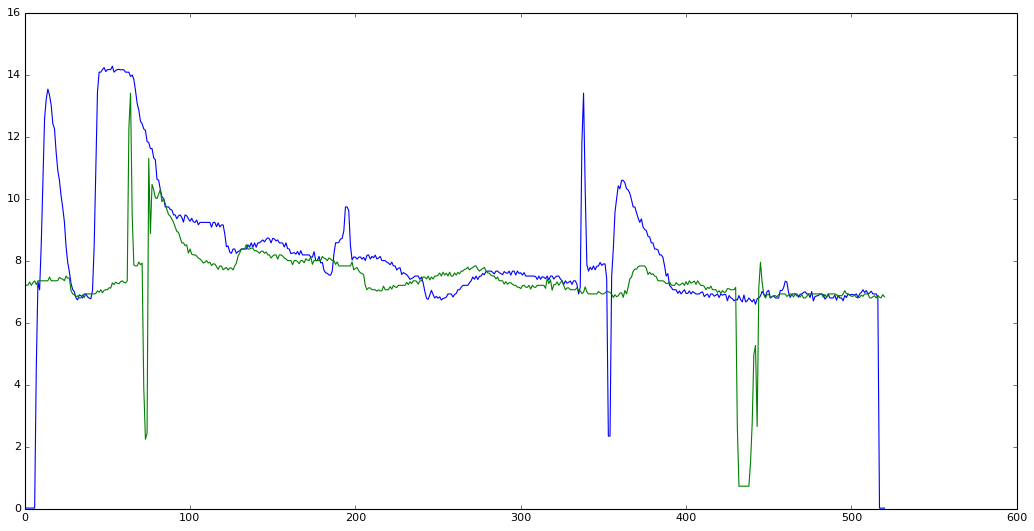

In [48]:
plot_matches(split_matches, True)

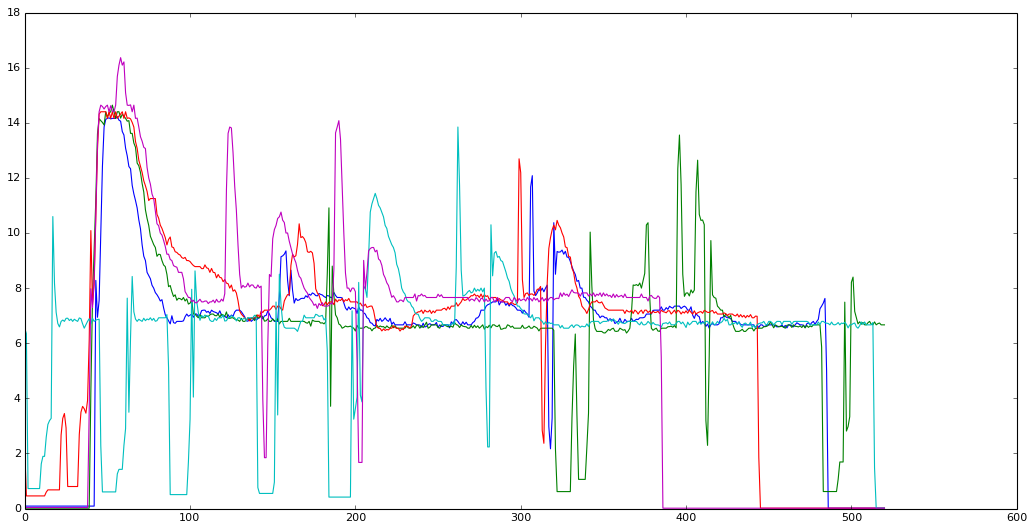

In [49]:
plot_matches(split_matches, False)

In [50]:
split_matches

,Type,Manhattan,startTimeStamp,stopTimeStamp,part_0,part_1
14,1,0.000000,2015-11-24 13:38:00+00:00,2015-11-24 22:14:00+00:00,8.96557,7.3704
12,2,631.003192,2015-11-22 12:22:00+00:00,2015-11-22 20:58:00+00:00,7.78166,6.89182
13,0,1024.983948,2015-11-23 14:09:00+00:00,2015-11-23 22:45:00+00:00,6.62577,6.22741
15,0,1059.452687,2015-11-25 04:40:00+00:00,2015-11-25 13:16:00+00:00,6.78755,6.20497
17,0,1084.521583,2015-11-26 14:16:00+00:00,2015-11-26 22:52:00+00:00,7.68669,5.36185
16,0,1230.842820,2015-11-25 13:40:00+00:00,2015-11-25 22:16:00+00:00,5.51256,6.81458
10,3,1543.273171,2015-11-20 15:43:00+00:00,2015-11-21 00:19:00+00:00,7.92189,3.72616
